In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [3]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "CIFAR-10"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

In [18]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASS_NAMES)

In [41]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

### Load CIFAR-10 data

In [62]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Image scaling to 0-1
# train_images = train_images / 255.0
# test_images = test_images / 255.0

if train_labels.ndim == 2:
    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()


total_data = f"Total Data on RAM -{(train_images.size + test_images.size) / 1024**2 : .2f} MB"
total_data

'Total Data on RAM - 175.78 MB'

### Displaying the first image in the training set

In [43]:
# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"(incorrect, {labels[i]})"
        plt.title(title)
        plt.axis("off")
    plt.show()
    

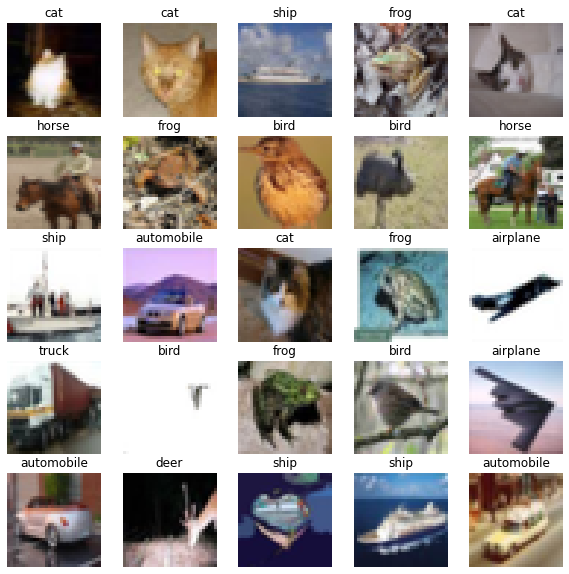

In [53]:
# display 25 random images from the training set
rnd_pts = np.random.randint(0, train_images.shape[0], 25)
images = train_images[rnd_pts, :, :]
labels = train_labels[rnd_pts]

display_image_grid(images, give_class_name(labels))

### Preprocessing the data

In [9]:
# One hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## MODELS

In [10]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Normalization, Rescaling

In [11]:
MODELS_PATH = ROOT_DIR / "models"
INPUT_SHAPE = train_images.shape[1:]

In [12]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)

### Create Models

TODO List - 
   - Improve Simple Sequential Model
     - Read and see other Models
   - Add more Models
     - Model with VGG-Like Blocks
     - Model with residual Blocks
     - Model With Inseption Blocks
     - Model With Mobile Blocks
     - Transfer Learning Models
       - VGG
       - ResNet
       - Inseption
       - Mobile

#### Simple Sequential Model

In [19]:
from tensorflow.keras.models import Sequential

def simple_sequential_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(Normalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(Normalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


### Training

In [14]:
# ploting the model training history

def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


#### Simple Sequential Model

In [15]:
model = simple_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 normalization (Normalizatio  (None, 32, 32, 32)       65        
 n)                                                              
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                              

2022-06-09 07:17:07.992306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 07:17:07.992641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 10))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/simple_sequential.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check]

In [17]:
history = model.fit(train_images, y_train, 
                    epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/30


2022-06-09 07:17:10.522054: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 07:17:10.849812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 1.7330 - accuracy: 0.3631

2022-06-09 07:17:20.559247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.51620, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 11s 17ms/step - loss: 1.7330 - accuracy: 0.3631 - val_loss: 1.3491 - val_accuracy: 0.5162
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.3540 - accuracy: 0.5142
Epoch 2: val_accuracy improved from 0.51620 to 0.59290, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 11s 17ms/step - loss: 1.3540 - accuracy: 0.5142 - val_loss: 1.1642 - val_accuracy: 0.5929
Epoch 3/30
623/625 [============================>.] - ETA: 0s - loss: 1.2004 - accuracy: 0.5760
Epoch 3: val_accuracy improved from 0.59290 to 0.61890, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 11s 18ms/ste

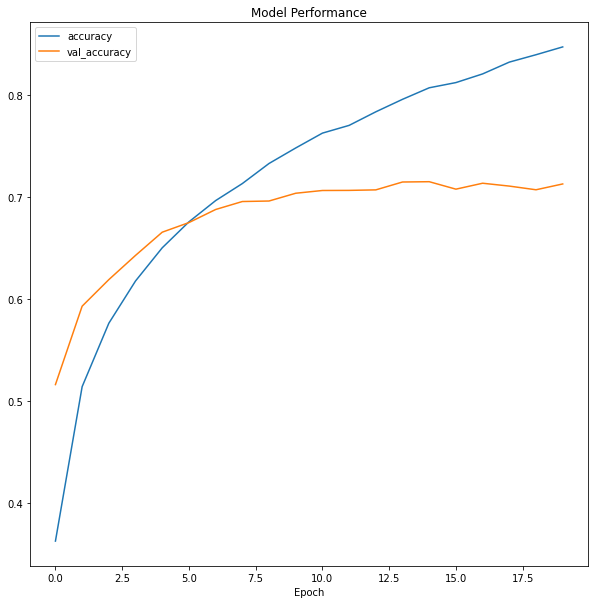

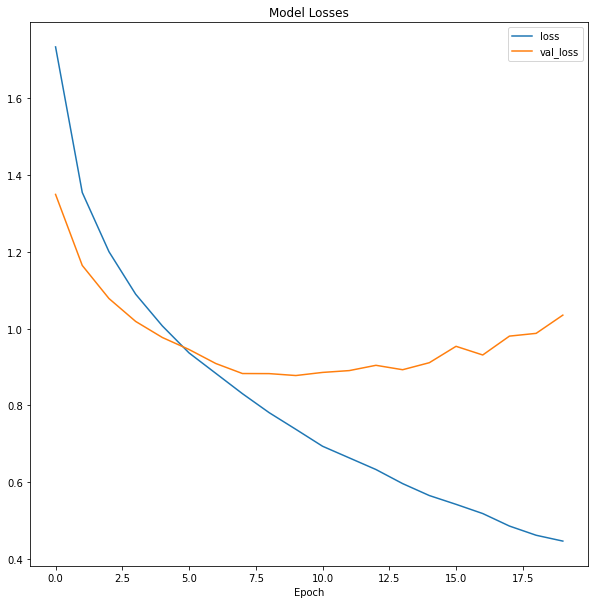

In [20]:
plot_model_performance(history)

In [21]:
model.evaluate(test_images, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.0426 - accuracy: 0.7099


[1.0425612926483154, 0.7099000215530396]

## Testing Performance

In [22]:
from sklearn.metrics import confusion_matrix, classification_report 

def confusion_matrix_plot(y_test, y_pred, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    plt.show()
    
def classification_report_plot(y_test, y_pred, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    cr = classification_report(y_test, y_pred, output_dict=True)
    cr_heatmap = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.2f')
    cr_heatmap.set_title('Classification Report')
    cr_heatmap.set_xlabel('Metrics')
    cr_heatmap.set_ylabel('Classes')
    plt.show()

### Simple Sequential Model

In [23]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/simple_sequential.h5')

#### Performance Heatmap

2022-06-09 07:23:36.358773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.7047


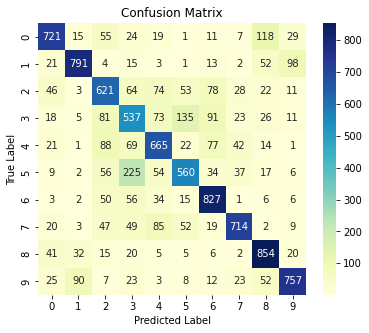

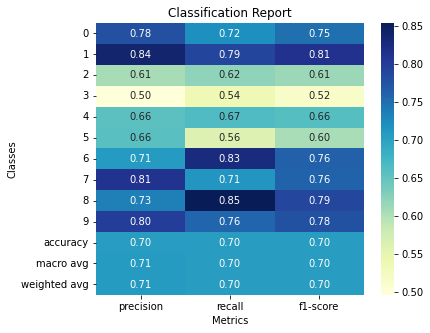

In [24]:
#  confusion matrix and classification report
from sklearn.metrics import accuracy_score

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)
print("Accuracy:", accuracy_score(y, test_labels_pred))
confusion_matrix_plot(y, test_labels_pred, figsize=(6, 5))
classification_report_plot(y, test_labels_pred, figsize=(6, 5))


#### Data Visualization

In [57]:
test_labels

array([158, 112,  49, ...,  27,  26,  26], dtype=uint8)

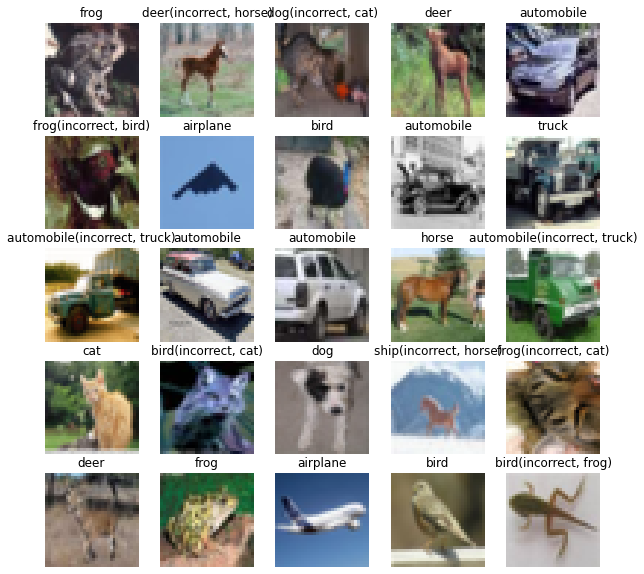

In [59]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


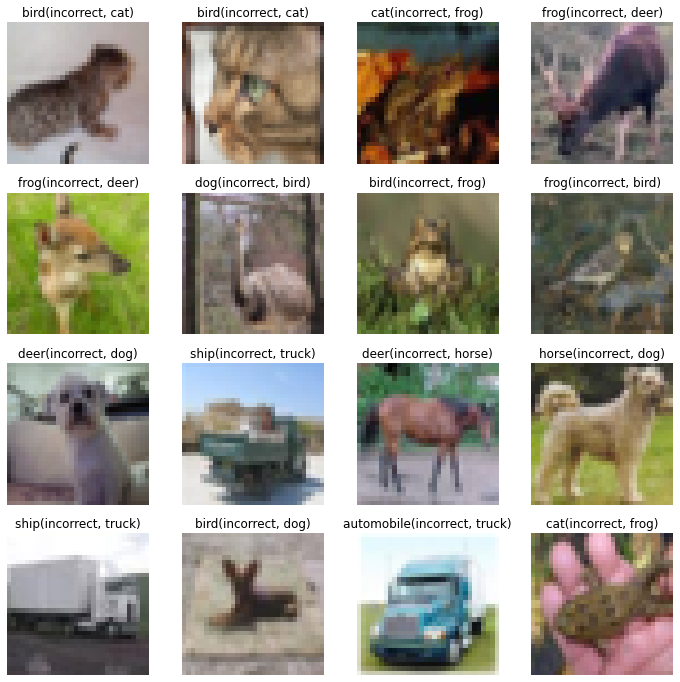

In [71]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

## Results

### 70% is not good enough accuracy, Will apply more models untill we get good results

### Simple Sequential Model with Dropout

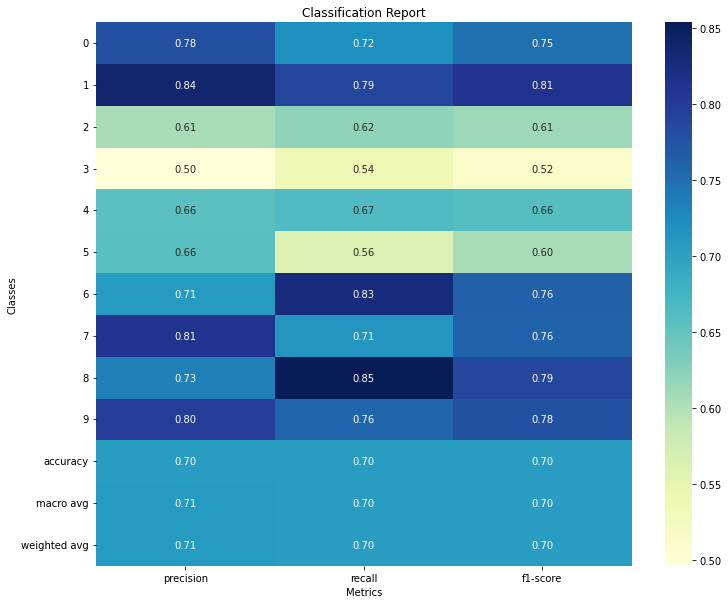

In [75]:
classification_report_plot(y, test_labels_pred)